# **Camelyon-17 Experiments**

## **Dependencies**

In [1]:
!pip install wilds
!pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torchvision.models import resnet50

from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader, get_eval_loader
from wilds.common.grouper import CombinatorialGrouper

import sys
import os
from google.colab import drive, output
from collections import defaultdict
import copy

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from captum.attr import IntegratedGradients
from matplotlib.colors import LinearSegmentedColormap

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
os.makedirs('./data', exist_ok=True)
os.makedirs('./data/camelyon17_v1.0', exist_ok=True)
drive.mount('/content/drive')

!tar -xvzf /content/drive/MyDrive/research/biostat/data/camelyon17_v1.0.tar.gz -C ./data/camelyon17_v1.0

Streaming output truncated to the last 5000 lines.
./patches/patient_081_node_4/patch_patient_081_node_4_x_20704_y_1120.png
./patches/patient_081_node_4/patch_patient_081_node_4_x_4064_y_9344.png
./patches/patient_081_node_4/patch_patient_081_node_4_x_18784_y_2400.png
./patches/patient_081_node_4/patch_patient_081_node_4_x_21440_y_3520.png
./patches/patient_081_node_4/patch_patient_081_node_4_x_16320_y_10112.png
./patches/patient_081_node_4/patch_patient_081_node_4_x_5312_y_9216.png
./patches/patient_081_node_4/patch_patient_081_node_4_x_13344_y_9344.png
./patches/patient_081_node_4/patch_patient_081_node_4_x_17024_y_6624.png
./patches/patient_081_node_4/patch_patient_081_node_4_x_7648_y_3392.png
./patches/patient_081_node_4/patch_patient_081_node_4_x_2784_y_9568.png
./patches/patient_081_node_4/patch_patient_081_node_4_x_9056_y_6048.png
./patches/patient_081_node_4/patch_patient_081_node_4_x_11072_y_15808.png
./patches/patient_081_node_4/patch_patient_081_node_4_x_22720_y_3520.png
./p

## **Data Processing**

In [4]:
camelyon17_dir = "./data"
dataset = get_dataset(dataset="camelyon17", root_dir = camelyon17_dir, download = False)
print(dataset.metadata_fields)

['hospital', 'slide', 'y', 'from_source_domain']


In [5]:
height = 224
train_transform = transforms.Compose(
        [ # add some augmentation
            transforms.Resize((height, height)), transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ] # imagenet params
    )
eval_transform = transforms.Compose(
        [transforms.Resize((height, height)), transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))] # imagenet params
    )

train_data = dataset.get_subset(
    "train",
    transform=train_transform
)
val_data = dataset.get_subset(
    "val",
    transform=eval_transform
)
# val_data, _ = data.random_split(val_data, [VAL_SIZE, len(val_data) - VAL_SIZE])

test_data = dataset.get_subset(
    "test",
    transform=eval_transform
)
# test_data, _ = data.random_split(test_data, [TEST_SIZE, len(test_data) - TEST_SIZE])

In [6]:
batch_size = 64
train_loader = get_train_loader("standard", train_data, batch_size = batch_size)
val_loader = get_eval_loader("standard", val_data, batch_size = batch_size)
test_loader = get_eval_loader("standard", test_data, batch_size = batch_size)

In [7]:
# custom data

grouper = CombinatorialGrouper(dataset, ['hospital'])

# lets use 10k samples
TRAIN_SIZE = 5000
remaining_samples = TRAIN_SIZE

print(f"Total samples remaining: {remaining_samples}")
train_x = []
train_y = []
train_z = []
for x, y, metadata in train_loader:
    
    if remaining_samples > 0:
        train_x.append(x)
        train_y.append(y)
        train_z.append(grouper.metadata_to_group(metadata)) # hospital
    else:
        break

    remaining_samples -= batch_size
    output.clear()
    print(f"Total samples remaining: {remaining_samples}")

train_x = torch.cat(train_x)
train_y = torch.cat(train_y)
train_z = torch.cat(train_z) # if want domain

Total samples remaining: -56


In [8]:
# custom data

grouper = CombinatorialGrouper(dataset, ['hospital'])
VAL_SIZE = 2500


# lets use 10k samples
remaining_samples = VAL_SIZE

print(f"Total samples remaining: {remaining_samples}")
val_x = []
val_y = []
val_z = []
for x, y, metadata in val_loader:
    # get label = 0
    if remaining_samples > VAL_SIZE // 2 and y.sum() != 0:
        # print("sub")
        val_x.append(x)
        val_y.append(y)
        val_z.append(grouper.metadata_to_group(metadata)) # hospital
        remaining_samples -= batch_size
    # get label = 1
    elif remaining_samples <= VAL_SIZE // 2 and remaining_samples >= 0 and y.sum() == 0:
        val_x.append(x)
        val_y.append(y)
        val_z.append(grouper.metadata_to_group(metadata)) # hospital
        remaining_samples -= batch_size
    elif remaining_samples >= 0:
        continue
    else:
        break

    output.clear()
    print(f"Total samples remaining: {remaining_samples}")

val_x = torch.cat(val_x)
val_y = torch.cat(val_y)
val_z = torch.cat(val_z) # if want domain

Total samples remaining: -60


In [9]:
# train on hosp 0, hosp 3, hosp 4 subset, eval on hosp 1, test on hosp 2# custom data

grouper = CombinatorialGrouper(dataset, ['hospital'])
TEST_SIZE = 7500
# lets use 10k samples
remaining_samples = TEST_SIZE

print(f"Total samples remaining: {remaining_samples}")
test_x = []
test_y = []
test_z = []
for x, y, metadata in test_loader:
    # get label = 0
    if remaining_samples > TEST_SIZE // 2 and y.sum() != 0:
        # print("sub")
        test_x.append(x)
        test_y.append(y)
        test_z.append(grouper.metadata_to_group(metadata)) # hospital
        remaining_samples -= batch_size
    # get label = 1
    elif remaining_samples <= TEST_SIZE // 2 and remaining_samples >= 0 and y.sum() == 0:
        test_x.append(x)
        test_y.append(y)
        test_z.append(grouper.metadata_to_group(metadata)) # hospital
        remaining_samples -= batch_size
    elif remaining_samples >= 0:
        continue
    else:
        break

    output.clear()
    print(f"Total samples remaining: {remaining_samples}")

test_x = torch.cat(test_x)
test_y = torch.cat(test_y)
test_z = torch.cat(test_z) # if want domain


Total samples remaining: -52


In [10]:
print(val_y.sum(), test_y.sum())

tensor(1280) tensor(3776)


In [11]:
class CamelyonDataset(Dataset):
    def __init__(self, x, y, z):
        """
        Tensors to pass:
        x -- data of interest
        y -- outcome
        """
        self.x = x
        self.y = y
        self.z = z # to match val/test loaders

    def __getitem__(self, index):
        x = self.x[index, ...]
        y = self.y[index]
        z = self.z[index]
        return x, y, z 
    
    def __len__(self):
        return len(self.x) # number of

In [12]:
batch_size = 64
train_dataset = CamelyonDataset(train_x, train_y, train_z)
val_dataset = CamelyonDataset(val_x, val_y, val_z)
test_dataset = CamelyonDataset(test_x, test_y, test_z)

train_loader = DataLoader(train_dataset, shuffle = True, batch_size = batch_size)
val_loader = DataLoader(val_dataset, shuffle = False, batch_size = batch_size)
test_loader = DataLoader(test_dataset, shuffle = False, batch_size = batch_size)

## **Model and Loss**

### **Loss**

In [13]:
# https://github.com/HobbitLong/SupContrast/blob/master/losses.py
"""
Author: Yonglong Tian (yonglong@mit.edu)
Date: May 07, 2020
"""
from __future__ import print_function

import torch
import torch.nn as nn


class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR
    
    -- Ryan
    Modifications made as per https://github.com/HobbitLong/SupContrast/issues/104
    """
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        # normalize
        features = torch.nn.functional.normalize(features, p=2, dim=2)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one': # compare to one anchor
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all': # compare all
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-6)

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask*log_prob).sum(1)/(mask.sum(1)+1e-6)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

In [14]:
# https://github.com/Prasanna1991/DisPred/blob/main/utils.py
class SupConLoss(nn.Module):
    #SupConLoss(temperature = temp, 
                        #    contrast_mode = 'all', 
                        #    base_temperature = 0.07),
    def __init__(self, temperature, contrast_mode, base_temperature):
        super(SupConLoss, self).__init__()
        self.base_temperature=base_temperature
        self.temperature = temperature
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def forward(self, features, labels, normalize=True):
        if normalize:
            features = F.normalize(features, dim=1)
        features = features.repeat(1,2).view(features.size(0), 2, -1) # 2N by adding a column
        labels = labels.contiguous().view(-1, 1)
        # element-wise equality 
        mask = torch.eq(labels, torch.t(labels)).float().to(self.device) 
        contrast_count = features.shape[1] # N
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)

        # simply replicate features for the 2N features
        anchor_feature = contrast_feature 
        anchor_count = contrast_count

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, torch.t(contrast_feature)), # (zi @ zs)/t
            self.temperature)
        
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach() # centering

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)  # repeats mask N rows and N cols

        # mask-out self-contrast cases
        logits_mask = torch.ones_like(mask).scatter_(1,
            torch.arange(features.size(0) * anchor_count).view(-1, 1).to(self.device),
            0
        ).to(device)

        mask = mask * logits_mask 

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask 
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive for given example 
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, features.size(0)).mean() # over all examples

        return loss

### **Model**

In [15]:
class ResNetFeat(nn.Module):
    """
    resnet feature extractor
    """
    def __init__(self, num_channels, num_classes):
        super(ResNetFeat, self).__init__()
        self.resnet = resnet50(weights = None)#'IMAGENET1K_V2') # finetuning
        self.resnet.conv1 = nn.Conv2d(num_channels, 64, 7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Linear(2048, num_classes) 
        self.feature_extractor = torch.nn.Sequential(*list(self.resnet.children())[:-1])

    def forward(self, x):
        z = self.feature_extractor(x)
        return z.view(z.shape[0], -1)#.unsqueeze(1)

    # def forward(self, x):
    #     return self.resnet(x)

In [16]:
class ResNet50(nn.Module):
  def __init__(self, num_classes):
    # super class 
    super(ResNet50, self).__init__()
    self.resnet = resnet50(pretrained=False) # set with pretrained for now 

    # remove last layer: (fc): Linear(in_features=2048, out_features=1000, bias=True)
    self.features = nn.Sequential(*list(self.resnet.children())[:-1])

    # add layers 
    #model.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.fc = nn.Sequential(
        nn.Linear(in_features=self.resnet.fc.in_features, out_features=1000), 
        nn.BatchNorm1d(1000), 
        nn.Dropout(0.2), 
        nn.Linear(1000, 3)
    )
  
  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

## **Training**

### **Training Utils**

In [17]:
def pgd_linf(model, x, y, criterion, eps, step_size, adv_steps, randomize = True):
    """ 
    PGD l-inf norm
    https://adversarial-ml-tutorial.org/adversarial_examples/
    """
    if randomize: 
        delta = torch.rand_like(x, requires_grad=True) # uniform random -> can start pertubations at different locations
        delta.data = delta.data * 2 * eps - eps
    else:
        delta = torch.zeros_like(x, requires_grad=True) # start w/ no noise
        
    for t in range(adv_steps):
        z = model(x + delta)
        #print(z.shape)
        loss = criterion(z, y) # perturbed loss
        loss.backward() # gradiets wrt delta 
        delta.data = (delta + step_size*delta.grad.detach().sign()).clamp(-eps,eps) # linf clamp
        delta.grad.zero_() # reset grads
    return delta.detach() # optimal perturbation projected onto linf ball


In [18]:

def epoch_standard(model, criterion, loader, epoch, optimizer = None, device = 'cpu', show_acc = False):
    """
    standard epoch
    """
    if optimizer:
        model.train()
        mode = 'Train'
    else:
        model.eval()
        mode = 'Val'

    train_loss = []
    batches = tqdm(enumerate(loader), total=len(loader))
    batches.set_description("Epoch NA: Loss (NA)")
    correct = 0
    count = 0
    for batch_idx, (x, y, meta) in batches:
        x, y = x.to(device), y.to(device)
        # outer minimization
        z = model(x)
        #print(z.shape)
        loss = criterion(z, y)
        #print(loss.item())
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss.append(loss.item())

        if show_acc:
            correct += (z.max(axis = 1).indices == y).float().sum()
            count += y.shape[0]

        train_loss.append(loss.item())

        acc = 100 * correct / count if show_acc else torch.tensor([-1.0])

        batches.set_description(
            "Epoch {:d}: {:s} Loss ({:.2e}) ACC ({:.2e})".format(
                epoch, mode, loss.item(), acc.item()
            )
        )

    return np.mean(train_loss), acc.detach().cpu().numpy()#(100 * correct/count).detach().cpu().numpy()

def epoch_adversarial(model, criterion, loader, epoch, eps=0.2, step_size=1e-2, adv_steps=40, optimizer = None, device = 'cpu', show_acc = False):
    """
    eps -- l_inf bound
    step_size -- delta stepsize for inner maximization
    adv_steps -- number of steps of adversarial pertubation
    """
    if optimizer:
        model.train()
        mode = 'Train'
    else:
        model.eval()
        mode = 'Val'

    train_loss = []
    batches = tqdm(enumerate(loader), total=len(loader))
    batches.set_description("Epoch NA: Adversarial Loss (NA)")
    correct = 0
    count = 0
    for batch_idx, (x, y, meta) in batches:
        x, y = x.to(device), y.to(device)
        # inner maximization
        delta = pgd_linf(model, x, y, criterion, eps, step_size, adv_steps)

        # outer minimization
        z = model(x + delta)
        loss = criterion(z, y)
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss.append(loss.item())

        if show_acc:
            correct += (z.max(axis = 1).indices == y).float().sum()
            count += y.shape[0]
        acc = 100 * correct / count if show_acc else torch.tensor([-1.0])

        batches.set_description(
            "Adversarial Epoch {:d}: {:s} Loss ({:.2e}) ACC ({:.2e})".format(
                epoch, mode, loss.item(), acc.item()
            )
        )
    return np.mean(train_loss), acc.detach().cpu().numpy()

### **Fitting the Model**

### **Fitting Utils**

In [19]:
def fit_model(net, criterion, train_loader, val_loader, optimizer, n_epochs, adv_kwargs = dict(), device = 'cpu', use_adv = True, show_acc = False, use_val_acc = False):
    ###### Train Model ######
    train_losses = {'standard':[], 'adversarial':[]}
    val_losses = {'standard':[], 'adversarial':[]}
    best_val = float("inf")
    best_epoch = 0
    best_acc = 0
    train_accs = []
    val_accs = []

    for epoch in tqdm(range(n_epochs)):

        # train 
        train_loss, train_acc = epoch_standard(net, criterion, train_loader, epoch, optimizer, device = device, show_acc = show_acc)
        train_losses['standard'].append(train_loss)
        if show_acc:
            train_accs.append(train_acc)
        if use_adv:
            train_loss_adv, _ = epoch_adversarial(net, criterion, train_loader, epoch, **adv_kwargs, optimizer = optimizer, device = device, show_acc = show_acc)
            train_losses['adversarial'].append(train_loss_adv)

        # eval 
        val_loss, val_acc = epoch_standard(net, criterion, val_loader, epoch, optimizer = None, device = device, show_acc = show_acc)
        val_losses['standard'].append(val_loss)
        if show_acc:
            val_accs.append(val_acc)
        # if use_adv:
        #     val_loss_adv, _ = epoch_adversarial(net, criterion, val_loader, epoch, **adv_kwargs, optimizer = None, device = device, show_acc = show_acc)
        #     val_losses['adversarial'].append(val_loss_adv)
        
        

        # retain best val
        if not use_val_acc:
            if best_val >= val_losses[VAL_TYPE][-1]:
                best_val = val_losses[VAL_TYPE][-1]
                best_epoch = epoch
                print(f"Updating at {best_epoch}")
                # save model parameter/state dictionary
                best_model = copy.deepcopy(net.state_dict())
        else:
            if best_acc <= val_accs[-1]:
                best_acc = val_accs[-1]
                best_epoch = epoch
                print(f"Updating at {best_epoch}")
                # save model parameter/state dictionary
                best_model = copy.deepcopy(net.state_dict())

    # load best weights
    print(f"Best epoch at {best_epoch} with {VAL_TYPE} loss: {best_val}")
    net.load_state_dict(best_model)
    return train_losses, val_losses, train_accs, val_accs


### **Model Training**

In [20]:
NUM_EPOCHS = 20
LR = 3e-4
VAL_TYPE = 'standard' # or 'adversarial'

###### Supervised Contrastive Loss ######
temp = 0.07

###### Adversarial Parameters ######
adv_kwargs = {
    'eps':0.2, 
    'step_size':1e-2, 
    'adv_steps':10
}

In [21]:
num_classes = len(torch.unique(train_loader.dataset.y))
num_channels = 3
models = {
    'ce' : ResNet50(num_classes).to(device),
    'ce_adv' : ResNet50(num_classes).to(device),
    'supcon': ResNetFeat(num_channels, num_classes).to(device),
    'supcon_adv': ResNetFeat(num_channels, num_classes).to(device)
}

criterions = {
    'ce' : nn.CrossEntropyLoss(),
    'ce_adv' : nn.CrossEntropyLoss(),
    'supcon': SupConLoss(temperature = temp, 
                       contrast_mode = 'all', 
                       base_temperature = 0.07),
    'supcon_adv': SupConLoss(temperature = temp, 
                       contrast_mode = 'all', 
                       base_temperature = 0.07)
}

train_histories = {}
val_histories = {}
train_acc_histories = {}
val_acc_histories = {}

# might need to redefine resnet as its own class
# supcon takes in features, so would need to input 2nd last layer features
for model in tqdm(models):
    optimizer = torch.optim.AdamW(models[model].parameters(), lr = LR)
    adv = True if model.split('_')[-1] == 'adv' else False
    show_acc = True if 'ce' in model else False
    use_val_acc = True if 'ce' in model else False
    train_hist, val_hist, train_accs, val_accs = fit_model(models[model], criterions[model], 
                                     train_loader, val_loader, 
                                     optimizer, NUM_EPOCHS, adv_kwargs, 
                                     device = device, use_adv = adv,
                                     show_acc = show_acc, use_val_acc = use_val_acc)
    train_histories[model] = train_hist
    val_histories[model] = val_hist
    if 'ce' in model:
        train_acc_histories[model] = train_accs 
        val_acc_histories[model] = val_accs

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Updating at 0


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Updating at 1


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Updating at 5


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Updating at 8


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Updating at 17


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch at 17 with standard loss: inf


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Updating at 0


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Updating at 8


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Updating at 16


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Updating at 19
Best epoch at 19 with standard loss: inf


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Updating at 0


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch at 0 with standard loss: 4.903275454044342


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Updating at 0


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Updating at 2


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Updating at 3


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Updating at 4


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Updating at 5


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch at 5 with standard loss: 4.844236171245575


In [22]:
# train_histories
# {'ce': {'standard': [0.4831744555053832,
#    0.30398542476417145,
#    0.21277654585959035,
#    0.20188913690044155,
#    0.21807837707898284,
#    0.20661985147980194,
#    0.1809147080005724,
#    0.1639267306161832,
#    0.14206978506585466,
#    0.12020495972490008,
#    0.10733586636996723,
#    0.12003356928029392,
#    0.12447334341469067,
#    0.08276619212819805,
#    0.07857068003261392,
#    0.05062553132707371,
#    0.04747927077173526,
#    0.05951542410516192,
#    0.08429147170479351,
#    0.02852516313955848],
#   'adversarial': []},
#  'ce_adv': {'standard': [0.4679096790997288,
#    0.4950072555979596,
#    0.45249898345032824,
#    0.4576636875354791,
#    0.4790116720184495,
#    0.36158051615274406,
#    0.31215918554535393,
#    0.277048147554639,
#    0.2668659986951683,
#    0.2418530506989624,
#    0.23657316601351847,
#    0.2389815881659713,
#    0.23750382246850413,
#    0.22947942220334766,
#    0.21482921646365635,
#    0.21308513325226458,
#    0.21847608166782162,
#    0.21077312302740314,
#    0.19771724797879595,
#    0.20419149336558354],
#   'adversarial': [1.2389534123336212,
#    0.9197413347944429,
#    0.8111315377150909,
#    0.7950467195691941,
#    0.7306115793276436,
#    0.6791895409173603,
#    0.6639622698856306,
#    0.6311284194264231,
#    0.5797107027301306,
#    0.5711163101317007,
#    0.5767382330532316,
#    0.5260646614847304,
#    0.5318171977996826,
#    0.5196262764025338,
#    0.4984656153600427,
#    0.5156489742707603,
#    0.5014911935299258,
#    0.4921930798246891,
#    0.47961155938196787,
#    0.48197775777382185]}}

# val_histories
# {'ce': {'standard': [2.478033582121134,
#    1.3630406476557255,
#    0.9374852068722248,
#    1.9111404556781053,
#    1.5286296781152486,
#    2.429072156921029,
#    1.751748177409172,
#    1.360840991139412,
#    1.5247303783893584,
#    1.632867594063282,
#    2.0699615187942983,
#    2.1350823014974596,
#    1.3428521797060966,
#    2.482266092300415,
#    1.5686060294508934,
#    1.8783672526478767,
#    2.296904791891575,
#    2.5894934237003326,
#    1.983508476614952,
#    2.4641322761774065],
#   'adversarial': []},
#  'ce_adv': {'standard': [0.8470344334840775,
#    0.7718411795794964,
#    0.6907981991767883,
#    0.6937826327979565,
#    0.7934672027826309,
#    0.766726654022932,
#    0.7616313561797142,
#    0.9768812611699105,
#    0.740751377120614,
#    0.7266944844275713,
#    0.7316231533885003,
#    1.1230263276025654,
#    0.8198540635406971,
#    0.8713151536881923,
#    1.0832867436110973,
#    0.7925000071525574,
#    0.8069620665162802,
#    0.7123417139053345,
#    0.6568725068122149,
#    0.5893162943422794],
#   'adversarial': []}}

# train_acc_histories
# {'ce': [array(86.11551, dtype=float32),
#   array(91.317245, dtype=float32),
#   array(93.15665, dtype=float32),
#   array(93.196205, dtype=float32),
#   array(92.82041, dtype=float32),
#   array(93.334656, dtype=float32),
#   array(93.868675, dtype=float32),
#   array(94.3038, dtype=float32),
#   array(95.23339, dtype=float32),
#   array(96.004745, dtype=float32),
#   array(96.044304, dtype=float32),
#   array(95.8663, dtype=float32),
#   array(96.004745, dtype=float32),
#   array(97.17168, dtype=float32),
#   array(97.211235, dtype=float32),
#   array(98.16061, dtype=float32),
#   array(98.39795, dtype=float32),
#   array(98.16061, dtype=float32),
#   array(96.993675, dtype=float32),
#   array(99.12975, dtype=float32)],
#  'ce_adv': [array(87.163765, dtype=float32),
#   array(80.26108, dtype=float32),
#   array(79.92484, dtype=float32),
#   array(78.30301, dtype=float32),
#   array(76.60206, dtype=float32),
#   array(83.821205, dtype=float32),
#   array(88.17247, dtype=float32),
#   array(88.54826, dtype=float32),
#   array(89.45807, dtype=float32),
#   array(90.50633, dtype=float32),
#   array(91.06013, dtype=float32),
#   array(90.625, dtype=float32),
#   array(90.427216, dtype=float32),
#   array(91.59415, dtype=float32),
#   array(91.57437, dtype=float32),
#   array(91.71282, dtype=float32),
#   array(91.83149, dtype=float32),
#   array(91.61393, dtype=float32),
#   array(92.72152, dtype=float32),
#   array(91.96994, dtype=float32)]}

# val_acc_histories
# {'ce': [array(47.421875, dtype=float32),
#   array(53.125, dtype=float32),
#   array(65.19531, dtype=float32),
#   array(47.460938, dtype=float32),
#   array(46.992188, dtype=float32),
#   array(48.242188, dtype=float32),
#   array(49.609375, dtype=float32),
#   array(46.132812, dtype=float32),
#   array(56.328125, dtype=float32),
#   array(57.5, dtype=float32),
#   array(49.570312, dtype=float32),
#   array(51.679688, dtype=float32),
#   array(60.664062, dtype=float32),
#   array(54.140625, dtype=float32),
#   array(61.09375, dtype=float32),
#   array(62.65625, dtype=float32),
#   array(55.820312, dtype=float32),
#   array(56.171875, dtype=float32),
#   array(54.570312, dtype=float32),
#   array(56.289062, dtype=float32)],
#  'ce_adv': [array(56.40625, dtype=float32),
#   array(46.757812, dtype=float32),
#   array(55.078125, dtype=float32),
#   array(53.90625, dtype=float32),
#   array(49.375, dtype=float32),
#   array(48.007812, dtype=float32),
#   array(49.296875, dtype=float32),
#   array(47.34375, dtype=float32),
#   array(61.367188, dtype=float32),
#   array(55.351562, dtype=float32),
#   array(58.554688, dtype=float32),
#   array(47.65625, dtype=float32),
#   array(52.148438, dtype=float32),
#   array(49.921875, dtype=float32),
#   array(51.523438, dtype=float32),
#   array(59.609375, dtype=float32),
#   array(60.117188, dtype=float32),
#   array(59.140625, dtype=float32),
#   array(60.820312, dtype=float32),
#   array(66.328125, dtype=float32)]}

In [23]:
# models['supcon'] = ResNetFeat(num_channels, num_classes).to(device)
# models['supcon_adv'] = ResNetFeat(num_channels, num_classes).to(device)
# criterions['supcon'] = SupConLoss(temperature = temp, 
#                        contrast_mode = 'all', 
#                        base_temperature = 0.07)
# criterions['supcon_adv'] = SupConLoss(temperature = temp, 
#                        contrast_mode = 'all', 
#                        base_temperature = 0.07)

# i = 0
# for model in tqdm(models):
#     if i > 1:
#         optimizer = torch.optim.AdamW(models[model].parameters(), lr = LR)
#         adv = True if model.split('_')[-1] == 'adv' else False
#         show_acc = True if 'ce' in model else False
#         use_val_acc = True if 'ce' in model else False
#         train_hist, val_hist, train_accs, val_accs = fit_model(models[model], criterions[model], 
#                                         train_loader, val_loader, 
#                                         optimizer, NUM_EPOCHS, adv_kwargs, 
#                                         device = device, use_adv = adv,
#                                         show_acc = show_acc, use_val_acc = use_val_acc)
#         train_histories[model] = train_hist
#         val_histories[model] = val_hist
#         if 'ce' in model:
#             train_acc_histories[model] = train_accs 
#             val_acc_histories[model] = val_accs
#     else:
#         i += 1

In [24]:
# finetune SupCon to CE
models_ft = {
    'ce_supcon' : ResNet50(num_classes).to(device),
    'ce_supcon_adv' : ResNet50(num_classes).to(device)
}
models_ft['ce_supcon'].features = copy.deepcopy(models['supcon'].feature_extractor)
models_ft['ce_supcon_adv'].features = copy.deepcopy(models['supcon_adv'].feature_extractor)

criterions_ft = {
    'ce_supcon' : nn.CrossEntropyLoss(),
    'ce_supcon_adv' : nn.CrossEntropyLoss(),
}

for model in models_ft:
    optimizer = torch.optim.AdamW(models_ft[model].parameters(), lr = LR)
    adv = False
    show_acc = True if 'ce' in model else False
    use_val_acc = True if 'ce' in model else False
    train_hist, val_hist, train_accs, val_accs = fit_model(models_ft[model], criterions_ft[model], 
                                     train_loader, val_loader, 
                                     optimizer, NUM_EPOCHS, adv_kwargs, 
                                     device = device, use_adv = adv,
                                     show_acc = show_acc, 
                                     use_val_acc = use_val_acc)
    train_histories[model] = train_hist
    val_histories[model] = val_hist
    if 'ce' in model:
        train_acc_histories[model] = train_accs 
        val_acc_histories[model] = val_accs

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Updating at 0


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Updating at 1


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Updating at 2


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Updating at 4


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Updating at 8


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch at 8 with standard loss: inf


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Updating at 0


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Updating at 2


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch at 2 with standard loss: inf


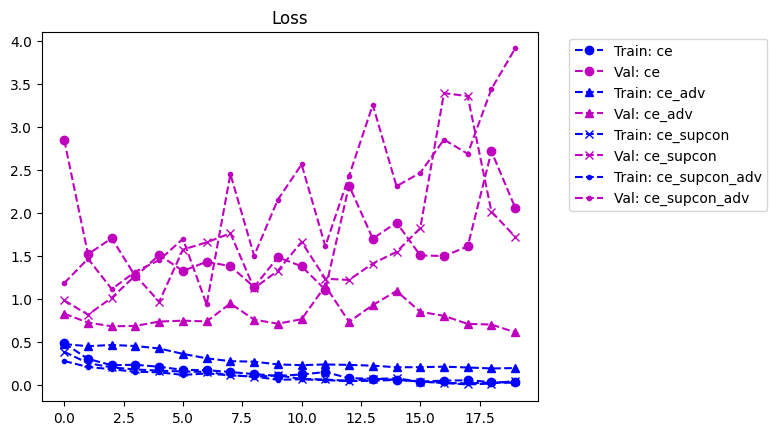

In [40]:
# BCE plots
model_list = ['ce', 'ce_adv', 'ce_supcon', 'ce_supcon_adv']
markers = ['o', '^', 'x', '.']
for i in range(4):
    plt.plot(list(range(NUM_EPOCHS)), train_histories[model_list[i]]['standard'], c = 'b', marker = markers[i], linestyle='dashed', label = f"Train: {model_list[i]}")
    plt.plot(list(range(NUM_EPOCHS)), val_histories[model_list[i]]['standard'], c = 'm', marker = markers[i], linestyle='dashed', label = f"Val: {model_list[i]}")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title("Loss")
plt.show()

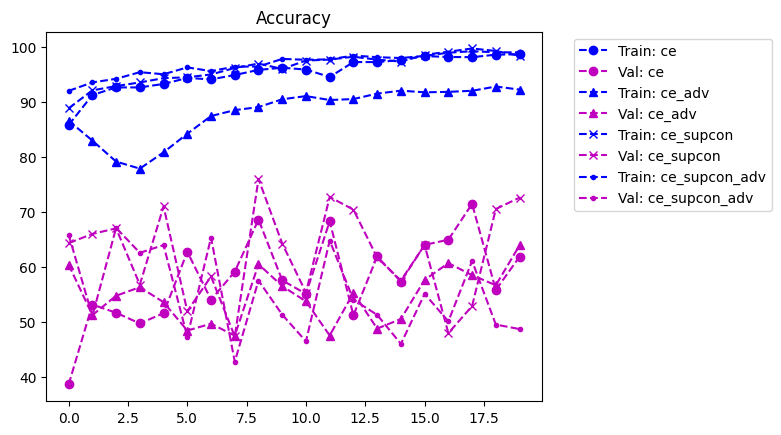

In [41]:
# ACC plots
model_list = ['ce', 'ce_adv', 'ce_supcon', 'ce_supcon_adv']
markers = ['o', '^', 'x', '.']
for i in range(4):
    plt.plot(list(range(NUM_EPOCHS)), train_acc_histories[model_list[i]], c = 'b', marker = markers[i], linestyle='dashed', label = f"Train: {model_list[i]}")
    plt.plot(list(range(NUM_EPOCHS)), val_acc_histories[model_list[i]], c = 'm', marker = markers[i], linestyle='dashed', label = f"Val: {model_list[i]}")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title("Accuracy")
plt.show()

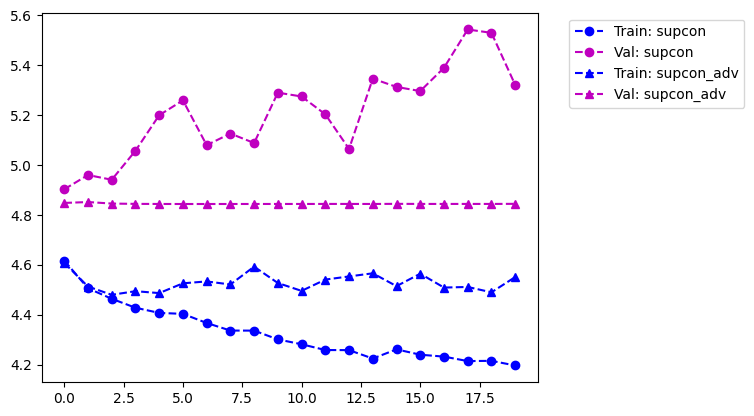

In [38]:
# SupCon plots
model_list = ['supcon', 'supcon_adv']
markers = ['o', '^']
for i in range(2):
    plt.plot(list(range(NUM_EPOCHS)), train_histories[model_list[i]]['standard'], c = 'b', marker = markers[i], linestyle='dashed', label = f"Train: {model_list[i]}")
    plt.plot(list(range(NUM_EPOCHS)), val_histories[model_list[i]]['standard'], c = 'm', marker = markers[i], linestyle='dashed', label = f"Val: {model_list[i]}")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [42]:
for model in models:
    torch.save(models[model].state_dict(), '/content/drive/MyDrive/harvard/6.8300/project/weights/' + model + '.pt')

### **Viz**

In [ ]:
# PCA of supcon -> make sure its working T_T

## **Interpretability**

### **Utils**

In [ ]:
# fixing captum.ai sourcecode to work with updated matplotlib

import warnings
from enum import Enum
from typing import Any, Iterable, List, Optional, Tuple, Union

import numpy as np
from matplotlib import cm, colors, pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.figure import Figure
from matplotlib.pyplot import axis, figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import ndarray

class ImageVisualizationMethod(Enum):
    heat_map = 1
    blended_heat_map = 2
    original_image = 3
    masked_image = 4
    alpha_scaling = 5


class TimeseriesVisualizationMethod(Enum):
    overlay_individual = 1
    overlay_combined = 2
    colored_graph = 3


class VisualizeSign(Enum):
    positive = 1
    absolute_value = 2
    negative = 3
    all = 4
def _prepare_image(attr_visual: ndarray):
    return np.clip(attr_visual.astype(int), 0, 255)


def _normalize_scale(attr: ndarray, scale_factor: float):
    assert scale_factor != 0, "Cannot normalize by scale factor = 0"
    if abs(scale_factor) < 1e-5:
        warnings.warn(
            "Attempting to normalize by value approximately 0, visualized results"
            "may be misleading. This likely means that attribution values are all"
            "close to 0."
        )
    attr_norm = attr / scale_factor
    return np.clip(attr_norm, -1, 1)


def _cumulative_sum_threshold(values: ndarray, percentile: Union[int, float]):
    # given values should be non-negative
    assert percentile >= 0 and percentile <= 100, (
        "Percentile for thresholding must be " "between 0 and 100 inclusive."
    )
    sorted_vals = np.sort(values.flatten())
    cum_sums = np.cumsum(sorted_vals)
    threshold_id = np.where(cum_sums >= cum_sums[-1] * 0.01 * percentile)[0][0]
    return sorted_vals[threshold_id]


def _normalize_attr(
    attr: ndarray,
    sign: str,
    outlier_perc: Union[int, float] = 2,
    reduction_axis: Optional[int] = None,
):
    attr_combined = attr
    if reduction_axis is not None:
        attr_combined = np.sum(attr, axis=reduction_axis)

    # Choose appropriate signed values and rescale, removing given outlier percentage.
    if VisualizeSign[sign] == VisualizeSign.all:
        threshold = _cumulative_sum_threshold(np.abs(attr_combined), 100 - outlier_perc)
    elif VisualizeSign[sign] == VisualizeSign.positive:
        attr_combined = (attr_combined > 0) * attr_combined
        threshold = _cumulative_sum_threshold(attr_combined, 100 - outlier_perc)
    elif VisualizeSign[sign] == VisualizeSign.negative:
        attr_combined = (attr_combined < 0) * attr_combined
        threshold = -1 * _cumulative_sum_threshold(
            np.abs(attr_combined), 100 - outlier_perc
        )
    elif VisualizeSign[sign] == VisualizeSign.absolute_value:
        attr_combined = np.abs(attr_combined)
        threshold = _cumulative_sum_threshold(attr_combined, 100 - outlier_perc)
    else:
        raise AssertionError("Visualize Sign type is not valid.")
    return _normalize_scale(attr_combined, threshold)


def visualize_image_attr(
    attr: ndarray,
    original_image: Union[None, ndarray] = None,
    method: str = "heat_map",
    sign: str = "absolute_value",
    plt_fig_axis: Union[None, Tuple[figure, axis]] = None,
    outlier_perc: Union[int, float] = 2,
    cmap: Union[None, str] = None,
    alpha_overlay: float = 0.5,
    show_colorbar: bool = False,
    title: Union[None, str] = None,
    fig_size: Tuple[int, int] = (6, 6),
    use_pyplot: bool = True,
):
    r"""
    Visualizes attribution for a given image by normalizing attribution values
    of the desired sign (positive, negative, absolute value, or all) and displaying
    them using the desired mode in a matplotlib figure.

    Args:

        attr (numpy.ndarray): Numpy array corresponding to attributions to be
                    visualized. Shape must be in the form (H, W, C), with
                    channels as last dimension. Shape must also match that of
                    the original image if provided.
        original_image (numpy.ndarray, optional): Numpy array corresponding to
                    original image. Shape must be in the form (H, W, C), with
                    channels as the last dimension. Image can be provided either
                    with float values in range 0-1 or int values between 0-255.
                    This is a necessary argument for any visualization method
                    which utilizes the original image.
                    Default: None
        method (str, optional): Chosen method for visualizing attribution.
                    Supported options are:

                    1. `heat_map` - Display heat map of chosen attributions

                    2. `blended_heat_map` - Overlay heat map over greyscale
                       version of original image. Parameter alpha_overlay
                       corresponds to alpha of heat map.

                    3. `original_image` - Only display original image.

                    4. `masked_image` - Mask image (pixel-wise multiply)
                       by normalized attribution values.

                    5. `alpha_scaling` - Sets alpha channel of each pixel
                       to be equal to normalized attribution value.

                    Default: `heat_map`
        sign (str, optional): Chosen sign of attributions to visualize. Supported
                    options are:

                    1. `positive` - Displays only positive pixel attributions.

                    2. `absolute_value` - Displays absolute value of
                       attributions.

                    3. `negative` - Displays only negative pixel attributions.

                    4. `all` - Displays both positive and negative attribution
                       values. This is not supported for `masked_image` or
                       `alpha_scaling` modes, since signed information cannot
                       be represented in these modes.

                    Default: `absolute_value`
        plt_fig_axis (tuple, optional): Tuple of matplotlib.pyplot.figure and axis
                    on which to visualize. If None is provided, then a new figure
                    and axis are created.
                    Default: None
        outlier_perc (float or int, optional): Top attribution values which
                    correspond to a total of outlier_perc percentage of the
                    total attribution are set to 1 and scaling is performed
                    using the minimum of these values. For sign=`all`, outliers
                    and scale value are computed using absolute value of
                    attributions.
                    Default: 2
        cmap (str, optional): String corresponding to desired colormap for
                    heatmap visualization. This defaults to "Reds" for negative
                    sign, "Blues" for absolute value, "Greens" for positive sign,
                    and a spectrum from red to green for all. Note that this
                    argument is only used for visualizations displaying heatmaps.
                    Default: None
        alpha_overlay (float, optional): Alpha to set for heatmap when using
                    `blended_heat_map` visualization mode, which overlays the
                    heat map over the greyscaled original image.
                    Default: 0.5
        show_colorbar (bool, optional): Displays colorbar for heatmap below
                    the visualization. If given method does not use a heatmap,
                    then a colormap axis is created and hidden. This is
                    necessary for appropriate alignment when visualizing
                    multiple plots, some with colorbars and some without.
                    Default: False
        title (str, optional): Title string for plot. If None, no title is
                    set.
                    Default: None
        fig_size (tuple, optional): Size of figure created.
                    Default: (6,6)
        use_pyplot (bool, optional): If true, uses pyplot to create and show
                    figure and displays the figure after creating. If False,
                    uses Matplotlib object oriented API and simply returns a
                    figure object without showing.
                    Default: True.

    Returns:
        2-element tuple of **figure**, **axis**:
        - **figure** (*matplotlib.pyplot.figure*):
                    Figure object on which visualization
                    is created. If plt_fig_axis argument is given, this is the
                    same figure provided.
        - **axis** (*matplotlib.pyplot.axis*):
                    Axis object on which visualization
                    is created. If plt_fig_axis argument is given, this is the
                    same axis provided.

    Examples::

        >>> # ImageClassifier takes a single input tensor of images Nx3x32x32,
        >>> # and returns an Nx10 tensor of class probabilities.
        >>> net = ImageClassifier()
        >>> ig = IntegratedGradients(net)
        >>> # Computes integrated gradients for class 3 for a given image .
        >>> attribution, delta = ig.attribute(orig_image, target=3)
        >>> # Displays blended heat map visualization of computed attributions.
        >>> _ = visualize_image_attr(attribution, orig_image, "blended_heat_map")
    """
    # Create plot if figure, axis not provided
    if plt_fig_axis is not None:
        plt_fig, plt_axis = plt_fig_axis
    else:
        if use_pyplot:
            plt_fig, plt_axis = plt.subplots(figsize=fig_size)
        else:
            plt_fig = Figure(figsize=fig_size)
            plt_axis = plt_fig.subplots()

    if original_image is not None:
        if np.max(original_image) <= 1.0:
            original_image = _prepare_image(original_image * 255)
    elif ImageVisualizationMethod[method] != ImageVisualizationMethod.heat_map:
        raise ValueError(
            "Original Image must be provided for"
            "any visualization other than heatmap."
        )

    # Remove ticks and tick labels from plot.
    plt_axis.xaxis.set_ticks_position("none")
    plt_axis.yaxis.set_ticks_position("none")
    plt_axis.set_yticklabels([])
    plt_axis.set_xticklabels([])
    #plt_axis.grid(b=None) -- source code does not work with this...

    heat_map = None
    # Show original image
    if ImageVisualizationMethod[method] == ImageVisualizationMethod.original_image:
        assert (
            original_image is not None
        ), "Original image expected for original_image method."
        if len(original_image.shape) > 2 and original_image.shape[2] == 1:
            original_image = np.squeeze(original_image, axis=2)
        plt_axis.imshow(original_image)
    else:
        # Choose appropriate signed attributions and normalize.
        norm_attr = _normalize_attr(attr, sign, outlier_perc, reduction_axis=2)

        # Set default colormap and bounds based on sign.
        if VisualizeSign[sign] == VisualizeSign.all:
            default_cmap = LinearSegmentedColormap.from_list(
                "RdWhGn", ["red", "white", "green"]
            )
            vmin, vmax = -1, 1
        elif VisualizeSign[sign] == VisualizeSign.positive:
            default_cmap = "Greens"
            vmin, vmax = 0, 1
        elif VisualizeSign[sign] == VisualizeSign.negative:
            default_cmap = "Reds"
            vmin, vmax = 0, 1
        elif VisualizeSign[sign] == VisualizeSign.absolute_value:
            default_cmap = "Blues"
            vmin, vmax = 0, 1
        else:
            raise AssertionError("Visualize Sign type is not valid.")
        cmap = cmap if cmap is not None else default_cmap

        # Show appropriate image visualization.
        if ImageVisualizationMethod[method] == ImageVisualizationMethod.heat_map:
            heat_map = plt_axis.imshow(norm_attr, cmap=cmap, vmin=vmin, vmax=vmax)
        elif (
            ImageVisualizationMethod[method]
            == ImageVisualizationMethod.blended_heat_map
        ):
            assert (
                original_image is not None
            ), "Original Image expected for blended_heat_map method."
            plt_axis.imshow(np.mean(original_image, axis=2), cmap="gray")
            heat_map = plt_axis.imshow(
                norm_attr, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha_overlay
            )
        elif ImageVisualizationMethod[method] == ImageVisualizationMethod.masked_image:
            assert VisualizeSign[sign] != VisualizeSign.all, (
                "Cannot display masked image with both positive and negative "
                "attributions, choose a different sign option."
            )
            plt_axis.imshow(
                _prepare_image(original_image * np.expand_dims(norm_attr, 2))
            )
        elif ImageVisualizationMethod[method] == ImageVisualizationMethod.alpha_scaling:
            assert VisualizeSign[sign] != VisualizeSign.all, (
                "Cannot display alpha scaling with both positive and negative "
                "attributions, choose a different sign option."
            )
            plt_axis.imshow(
                np.concatenate(
                    [
                        original_image,
                        _prepare_image(np.expand_dims(norm_attr, 2) * 255),
                    ],
                    axis=2,
                )
            )
        else:
            raise AssertionError("Visualize Method type is not valid.")

    # Add colorbar. If given method is not a heatmap and no colormap is relevant,
    # then a colormap axis is created and hidden. This is necessary for appropriate
    # alignment when visualizing multiple plots, some with heatmaps and some
    # without.
    if show_colorbar:
        axis_separator = make_axes_locatable(plt_axis)
        colorbar_axis = axis_separator.append_axes("bottom", size="5%", pad=0.1)
        if heat_map:
            plt_fig.colorbar(heat_map, orientation="horizontal", cax=colorbar_axis)
        else:
            colorbar_axis.axis("off")
    if title:
        plt_axis.set_title(title)

    if use_pyplot:
        plt.show()

    return plt_fig, plt_axis

In [ ]:
def explain_classifier(model, img, target, attr_kwargs = dict()):
    """
    Return integrated gradients for given prediction.

    Parameters:
        model -- Classifier of interest
        img -- Tensor of size batchsize x C x H x W 
        target -- Target label
        attr_kwargs -- Explainability method kwargs
    """
    ig = IntegratedGradients(model)
    img.requires_grad = True 
    attributes = ig.attribute(img.unsqueeze(1), 
                               target=target, 
                               **attr_kwargs)
    return attributes

# Captum.ai IG plotting functions
def visualize_classifier_exp(attr, img):
    default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

    _ = visualize_image_attr(attr.squeeze().cpu().detach().numpy(), # normalize over one channel/depth
                                img.squeeze().cpu().detach().numpy(),
                                method='heat_map',
                                cmap=default_cmap,
                                show_colorbar=True,
                                sign='positive',
                                outlier_perc=1)

### **Integrated Gradients**

In [ ]:
# explain_classifier(model, img, target, attr_kwargs = dict())